# Short-term electricity load forecasting 
### (Panama case study)

## User Input: Introduce your directories

In [4]:
# Base directory
base_dir = r'C:\Users\marti\.cache\kagglehub\datasets\ernestojaguilar\shortterm-electricity-load-forecasting-panama\versions\6'

# Directory to import cleaned and transformed dataframes for modelling
import_dir = base_dir + r''

# Directory to save models and optimization studies
models_dir = base_dir + r''

#### Context
These case study are framed on predicting the short-term electricity, this forecasting problem is known in the research field as short-term load forecasting (STLF). These datasets address the STLF problem for the Panama power system, in which the forecasting horizon is one week, with hourly steps, which is a total of 168 hours. These datasets are useful to train and test forecasting models and compare their results with the grid operator official forecast ([take a look at real-time electricity load](https://sitr.cnd.com.pa/m/pub/sin.html)). The datasets include historical load, a vast set of weather variables, holidays, and historical load weekly forecast features.

#### Objectives
The main objectives around these datasets are:
1. Evaluate the grid operator official forecasts (weekly pre-dispatch forecast) against the real load, on weekly basis.
2. Develop, train and test forecasting models to improve the operator official weekly forecasts (168 hours), in different scenarios.

#### Considerations to compare results
The following considerations should be kept to compare forecasting results with the weekly pre-dispatch forecast:

1. Saturday is the first day of each weekly forecast; for instance, Friday is the last day.
2. The first full-week starting on Saturday should be considered as the first week of the year, to number the weeks.
3. A 72 hours gap of unseen records should be considered before the first day to forecast. In other words, next week forecast should be done with records until each Tuesday last hour.
4. Make sure to train and test keeping the chronological order of records.

## Install libraries

In [5]:
!pip install ipython-autotime
%load_ext autotime

!pip install openpyxl
!pip install scikit-plot
!pip install optuna==2.3.0
!pip install plotly==4.14.1


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy

## Import packages

In [7]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from IPython import display
import plotly as plotly
%matplotlib inline

import calendar
import datetime as dt
from datetime import timedelta, date
from pprint import pprint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import joblib
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from scipy.stats import randint as sp_randint
from time import time
import pickle

import warnings
warnings.filterwarnings('ignore')

# set random_state
random_state = 123

time: 4.25 ms (started: 2025-10-07 16:23:03 +02:00)


## Animation of the 14 suggested training-testing pairs along the horizon 

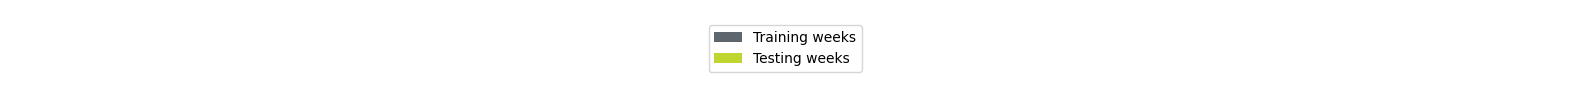

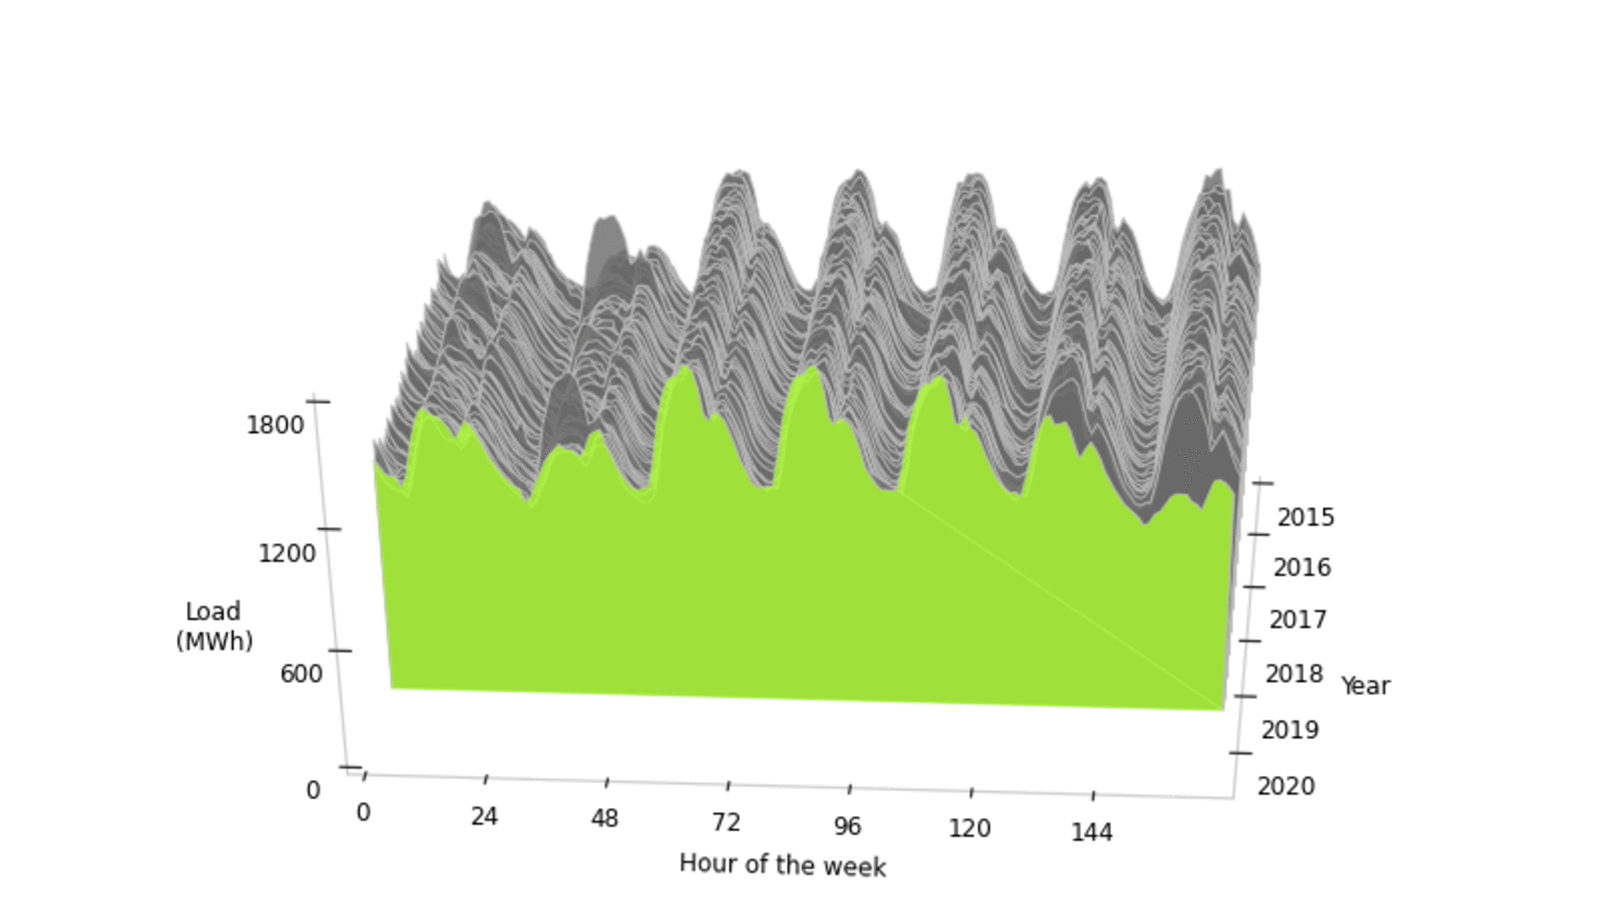

time: 173 ms (started: 2025-10-07 16:23:08 +02:00)


In [8]:
# set the working directory
os.chdir(import_dir)

# Add legend
legend_elements = [Patch(facecolor='#5D666D', label='Training weeks'),
                   Patch(facecolor='#BFD630', label='Testing weeks')]
fig, ax = plt.subplots(figsize=(20,1))
ax.legend(handles=legend_elements, loc='center')
plt.axis('off')
plt.show()
# Display gif
display.Image(r'Animated_3D_plot.gif')

The continious dataset was split into train and test datasets, keeping the cronological order of the records, this is, keeping records sorted by 'datetime', leaving always the **last week for testing the model and the rest, older data for training it.** <br>

Based on this logic, there will be 14 pairs of train/test datasets. 12 pairs with the testing week on each month of the last year of records, before the quarentine started, and 2 more testing weeks after the quarentine started. As a fact, the lockdown in Panama started on Wednesday March 25th of 2020 (week 12 - 2020). <br>

The following table shows more information about the train/test splits: <br>

In [5]:
# +---------------------+-------------------+---------------------+
# | testing week number | testing week name |   datetime split    |
# +---------------------+-------------------+---------------------+
# |                   1 | Week 15, Apr 2019 | 2019-04-13 01:00:00 |
# |                   2 | Week 21, May 2019 | 2019-05-25 01:00:00 |
# |                   3 | Week 24, Jun 2019 | 2019-06-15 01:00:00 |
# |                   4 | Week 29, Jul 2019 | 2019-07-20 01:00:00 |
# |                   5 | Week 33, Aug 2019 | 2019-08-17 01:00:00 |
# |                   6 | Week 37, Sep 2019 | 2019-09-14 01:00:00 |
# |                   7 | Week 41, Oct 2019 | 2019-10-12 01:00:00 |
# |                   8 | Week 44, Nov 2019 | 2019-11-02 01:00:00 |
# |                   9 | Week 51, Dec 2019 | 2019-12-21 01:00:00 |
# |                  10 | Week 01, Jan 2020 | 2020-01-04 01:00:00 |
# |                  11 | Week 06, Feb 2020 | 2020-02-08 01:00:00 |
# |                  12 | Week 10, Mar 2020 | 2020-03-07 01:00:00 |
# |                  13 | Week 20, May 2020 | 2020-05-16 01:00:00 |
# |                  14 | Week 24, Jun 2020 | 2020-06-13 01:00:00 |
# +---------------------+-------------------+---------------------+

# 1.0 Import datasets

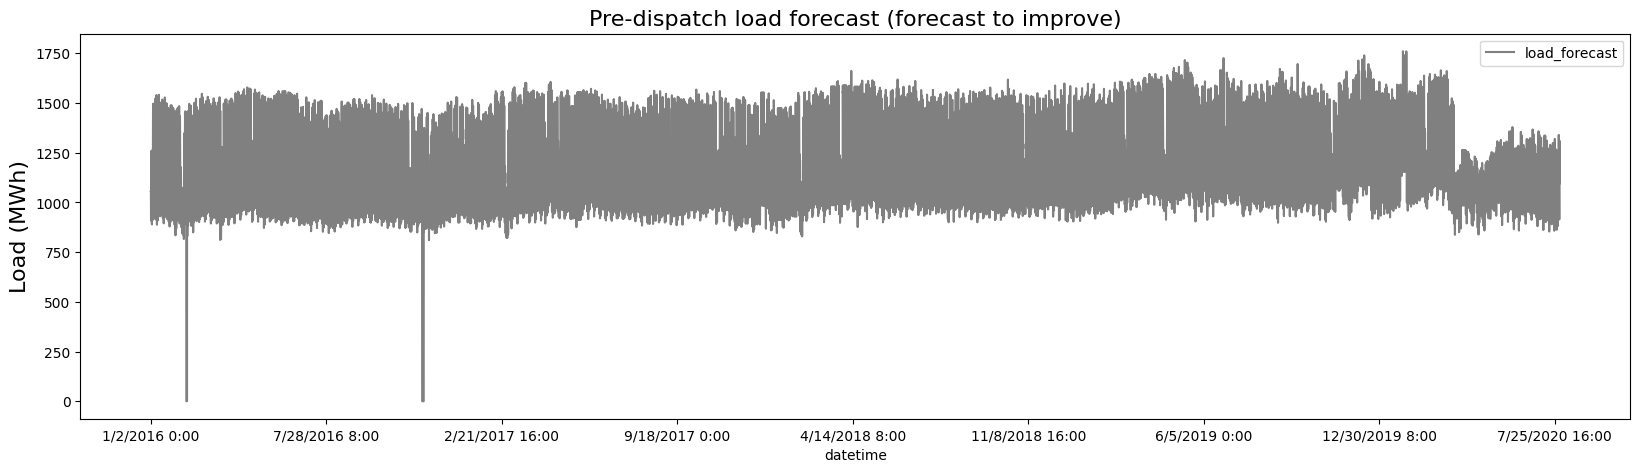

time: 481 ms (started: 2025-10-07 16:30:32 +02:00)


In [9]:
# set the working directory
os.chdir(import_dir)

# csv file with load forecast to improve (weekly pre-dispatch)
filename = 'weekly pre-dispatch forecast.csv'

# Read the file and convert into "pre_disp_df" 
pre_disp_df = pd.read_csv(filename)

# set datetime as index
pre_disp_df.set_index('datetime', inplace=True)

# plot weekly pre-dispatch forecast (forecast to improve)
pre_disp_df.plot(figsize=(20,5), color='grey')
plt.title('Pre-dispatch load forecast (forecast to improve)', fontsize=16)
plt.ylabel('Load (MWh)', fontsize=16);

In [10]:
# set the working directory
os.chdir(import_dir)

# Import a dictionary with all the training dataframes
# Use parameter sheet_name=None, from pd.read_excel
# to return a dictionary of Dataframes, with the sheet_names as dictionary keys.
train_dict = pd.read_excel(open('train_dataframes.xlsx', 'rb'), sheet_name = None, index_col=0)

# Import a dictionary with all the testing dataframes
test_dict = pd.read_excel(open('test_dataframes.xlsx', 'rb'), sheet_name = None, index_col=0)

time: 47.1 s (started: 2025-10-07 16:31:25 +02:00)


In [11]:
# Get the keys from 'test_dict' dictionary
# keys are the same for both 'test_dict' and 'train_dict'
keys = list(test_dict.keys())

# Show keys
keys

['Week 15, Apr 2019',
 'Week 21, May 2019',
 'Week 24, Jun 2019',
 'Week 29, Jul 2019',
 'Week 33, Aug 2019',
 'Week 37, Sep 2019',
 'Week 41, Oct 2019',
 'Week 44, Nov 2019',
 'Week 51, Dec 2019',
 'Week 01, Jan 2020',
 'Week 06, Feb 2020',
 'Week 10, Mar 2020',
 'Week 20, May 2020',
 'Week 24, Jun 2020']

time: 3.51 ms (started: 2025-10-07 16:32:21 +02:00)


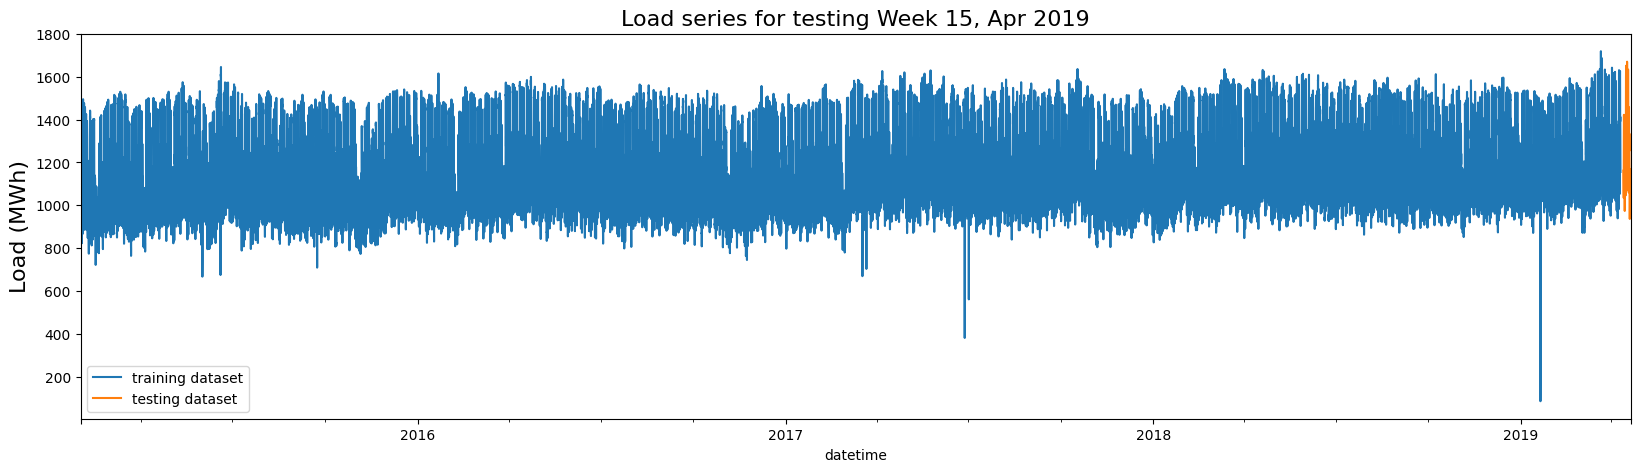

time: 527 ms (started: 2025-10-07 16:32:40 +02:00)


In [12]:
# Plot the electricity load, just for the first training/testing pair 
# notice the small gap between the two series, it's the 72 hours gap
train_dict[keys[0]]['DEMAND'].plot(figsize=(20,5), label='training dataset')
test_dict[keys[0]]['DEMAND'].plot(figsize=(20,5), label='testing dataset')
plt.ylabel('Load (MWh)', fontsize=16)
plt.title('Load series for testing ' + keys[0],fontsize=16)
plt.legend();

# 2.0 Define functions

In [13]:
################################################################################
# ------------------------- MAPE evaluation functions --------------------------
################################################################################

# Define a function to calculate WEEKLY Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

# Define a function to calculate HOURLY Mean Absolute Percentage Error (MAPE)
def H_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    H_MAPE = (np.abs((y_true - y_pred) / y_true) * 100)
    rounded_H_MAPE = [round(num, 1) for num in H_MAPE]
    return rounded_H_MAPE

time: 2.52 ms (started: 2025-10-07 16:35:18 +02:00)


In [14]:
################################################################################
# ------------------ Time-based train and test splitting -----------------------
################################################################################
# Reference:
# https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period'+'-gap)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period'+'-gap)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 

time: 4.61 ms (started: 2025-10-07 16:35:32 +02:00)


In [15]:
################################################################################
# ------------------- Plotting test and demand forecast  -----------------------
################################################################################

def plot_test_forecast(y_test, y_pred_test, y_pre_disp):
  # Calculate values to plot
  delta_demand = y_test - y_pred_test
  H_MAPE = H_mean_absolute_percentage_error(y_test, y_pred_test)

  import matplotlib.pyplot
  from matplotlib.ticker import MaxNLocator
  import matplotlib.ticker
  fig, (ax, bx) = plt.subplots(1,2, figsize=(20, 5))
  matplotlib.rc('xtick', labelsize=12) 
  matplotlib.rc('ytick', labelsize=12) 

  # First plot
  ax.plot(np.arange(1, 169, 1), y_test, c= 'green', label = 'Real Demand')
  ax.plot(np.arange(1, 169, 1), y_pred_test, c= 'red', label = 'Demand Forecast')
  ax.plot(np.arange(1, 169, 1), y_pre_disp, c= 'gray', linestyle='--', label = 'Pre-dispatch Forecast')
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.set_xlabel('Hours of the week', fontsize = 12)
  ax.set_ylabel('MWh', rotation=0, fontsize = 12, labelpad=20)
  ax.set_title('Real demand vs Forecasts')
    
  # Second plot
  bx.bar(np.arange(1, 169, 1), delta_demand, width=1.0, color = 'grey', label = 'Error')
  bx.xaxis.set_major_locator(MaxNLocator(integer=True))
  bx.set_xlabel('Hours of the week', fontsize = 12)
  bx.set_ylabel('MWh', rotation=0, fontsize = 12, labelpad=5)
  bx.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
  bx2 = bx.twinx()  # instantiate a second axes that shares the same x-axis
  legend = ax.legend(loc='lower left', fontsize = 12)
  bx.set_title('Forecast errors and MAPE')

  # Calculate weekly MAPE to improve
  MAPE2improve = mean_absolute_percentage_error(y_test, y_pre_disp)

  color = 'tab:blue'
  bx2.set_ylabel('MAPE', color=color, labelpad=20, rotation=0, fontsize = 12)
  bx2.plot(np.arange(1, 169, 1), H_MAPE, color=color, label = 'Absolute Error (%)')
  bx2.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0))
  bx2.tick_params(axis='y', labelcolor=color)
  bx2.set_ylim(bottom=0)
  plt.axhline(y=MAPE2improve, color='k', linestyle='--', label = str('Error cap (' + str(MAPE2improve)+'%)'))
  legend = bx.legend(loc='upper left', fontsize = 12)
  legend = bx2.legend(loc='upper right', fontsize = 12)

  fig.tight_layout()
  plt.show()

time: 4.33 ms (started: 2025-10-07 16:36:23 +02:00)


In [16]:
################################################################################
# ------------------ Define a model inside a function --------------------------
################################################################################
# This function define the objective to optimize
# This function uses: X (regressors), y (target), 
#   and time-series cross-validation index
# This fuction returns the RMSE score for a trial
# The estimator or pipeline is fixed and defined inside
def model_hyperparameter_search(trial):

    # Define hyperparameter space
    space = {
            'n_neighbors'     : trial.suggest_int('n_neighbors', 3, 50, 2),
            'n_jobs'          : -1
            }
    
    # Define default regressor pipeline
    reg = Pipeline([('scaler', MinMaxScaler()), 
                    ('estimator', KNeighborsRegressor(**space)
                  )])
    
    # Define cross validation setting and evaluation metric
    rmse_cv_score = round(cross_val_score(reg, X, y, 
                           scoring = 'neg_root_mean_squared_error',
                           n_jobs = -1,
                           cv = index_output).mean(), 3)
    
    return rmse_cv_score

time: 2.86 ms (started: 2025-10-07 16:36:52 +02:00)


In [14]:
################################################################################
# ---------------------- Function to train a model --------------------------
################################################################################
# This function train a model
# This function uses: X_Train, y_train
# This fuction returns a trained and fitted model and the optimization study
# The estimator or pipeline is fixed and defined inside

def train_model(data_for_modeling):
    # -------------- Train the model using only the holidays data ---------------
    # Create a study object setting the sampling and direction 
    # of the optimization process (maximize -RMSE with Bayesian GMM)
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=random_state))
    # Define the function to optimize, number of trials, execution time and processors to use
    study.optimize(model_hyperparameter_search, n_trials=10, timeout=None, n_jobs=-1)
    # Fit the estimator using the best hyperparameters
    reg = Pipeline([('scaler', MinMaxScaler()), 
                    ('estimator', KNeighborsRegressor(**study.best_trial.params))])
    
    # ------------- Return trained model using only the holidays data -------------
    X_train = data_for_modeling.set_index(['record_date']).drop(columns=['DEMAND'])
    y_train = data_for_modeling['DEMAND']
    return reg.fit(X_train, y_train), study

# 3.0 Optimize models for each testing week

Notice keys list is contrained to its first element **keys[:1]** to run a fast demo <br>
select the whole list 'keys' to train 14 models

In [15]:
%%time
################################################################################
# -------------- Loop to optimize models for each testing week -----------------
################################################################################

for key in keys[:1]: 
    # 1. -------------------- Define weekly data to use ---------------------
    # Rename the training dataframe
    train_df = train_dict[key]

    # Select a single training and testing example, with the key name
    # and separate the target variable 'DEMAND'
    X_train = train_dict[key].drop(columns=['DEMAND'])
    X_test = test_dict[key].drop(columns=['DEMAND'])
    y_train = train_dict[key]['DEMAND']
    y_test  = test_dict[key]['DEMAND']
    
    # Reconstruct the pandas objects rounding hourly the datetime index
    # This cell is needed for some platforms
    train_df = pd.DataFrame(data=train_df.values, index=pd.Series(train_df.index).dt.round("H"), columns=train_df.columns)
    X_train = pd.DataFrame(data=X_train.values, index=pd.Series(X_train.index).dt.round("H"), columns=X_train.columns)
    X_test = pd.DataFrame(data=X_test.values, index=pd.Series(X_test.index).dt.round("H"), columns=X_test.columns)
    y_train = pd.Series(data=y_train.values, index=pd.Series(y_train.index).dt.round("H"), name=y_train.name)
    y_test = pd.Series(data=y_test.values, index=pd.Series(y_test.index).dt.round("H"), name=y_test.name)

    # Filter the pre-dispatch forecast only for the testing week
    y_pre_disp = pd.merge(y_test, pre_disp_df['load_forecast'], how='inner', left_index=True, right_index=True)['load_forecast']
    
    # 2. ----------------- Apply Time Based Cross Validation ----------------
    # 2.1. --------------- Time Based Cross Validation 
    # validation starts 64 weeks (1.23 years) before the last training record
    weeks_to_val = 64
    hours_to_val = (weeks_to_val*168 + 168)
    train_val_split  = train_df.index[(-hours_to_val)].strftime('%Y-%m-%d %H:%M:%S')
    
    # Create a Time Split Cross Validation object specifying 
    # 168 hours to test, this is a week for each CV fold
    tscv = TimeBasedCV(train_period = 25032,  # hours / 149 weeks / 2.8 years
                       test_period = 168,     # hours / 1 week
                       freq = 'hours')

    # Prepare dataframe before using TimeBasedCV
    data_for_modeling = train_df.reset_index(level=0)
    data_for_modeling.rename(columns={'datetime' : 'record_date'}, inplace=True)
    data_for_modeling['record_date'] =  pd.to_datetime(data_for_modeling['record_date'], format='%Y/%m/%d %H:%M:%S')  
    
    # 2.2 --------------- Prepare data for modelling and Cross Validation indexes
    # Set regressors dataframe 'X' and target 'y'
    X = data_for_modeling.drop(columns=['DEMAND', 'record_date'], axis=1)
    y = data_for_modeling['DEMAND']

    # Define each Cross Validation Fold using TimeBased splitter
    index_output = tscv.split(data_for_modeling, 
                          validation_split_date=dt.strptime(train_val_split, '%Y-%m-%d %H:%M:%S').date(),
                          gap = 72) # this is a 3 days gap needed for planning the next week dispatch 
    
    # 3. --------------- Modelling and optimizing hyperparameters ---------------
    # Train model, and return the fitted model and its optimization study
    generic_model, generic_model_study = train_model(data_for_modeling)
  
    # 4. --------------- Save the optimized and trained model in the selected folder -------
    # set the working directory
    os.chdir(models_dir)

    # save the Optuna study
    filename = 'KNN_study_'+ str(key) + '.pkl'
    joblib.dump(generic_model_study, filename)
    del filename
    
    # save the model
    filename = 'KNN_'+ str(key) + '.sav'
    pickle.dump(generic_model, open(filename, 'wb'))
    del filename

Train period: 2015-03-04 - 2018-01-07 , Test period 2018-01-10 - 2018-01-17 # train records 24960 , # test records 168
Train period: 2015-03-11 - 2018-01-14 , Test period 2018-01-17 - 2018-01-24 # train records 24960 , # test records 168
Train period: 2015-03-18 - 2018-01-21 , Test period 2018-01-24 - 2018-01-31 # train records 24960 , # test records 168
Train period: 2015-03-25 - 2018-01-28 , Test period 2018-01-31 - 2018-02-07 # train records 24960 , # test records 168
Train period: 2015-04-01 - 2018-02-04 , Test period 2018-02-07 - 2018-02-14 # train records 24960 , # test records 168
Train period: 2015-04-08 - 2018-02-11 , Test period 2018-02-14 - 2018-02-21 # train records 24960 , # test records 168
Train period: 2015-04-15 - 2018-02-18 , Test period 2018-02-21 - 2018-02-28 # train records 24960 , # test records 168
Train period: 2015-04-22 - 2018-02-25 , Test period 2018-02-28 - 2018-03-07 # train records 24960 , # test records 168
Train period: 2015-04-29 - 2018-03-04 , Test per

[I 2021-04-07 21:00:27,819] A new study created in memory with name: no-name-1644e952-1536-49e7-8118-edccf3bf82d2


, Test period 2019-03-13 - 2019-03-20 # train records 24960 , # test records 168
Train period: 2016-05-11 - 2019-03-17 , Test period 2019-03-20 - 2019-03-27 # train records 24960 , # test records 168
Train period: 2016-05-18 - 2019-03-24 , Test period 2019-03-27 - 2019-04-03 # train records 24960 , # test records 168


[I 2021-04-07 21:04:08,127] Trial 2 finished with value: -52.781 and parameters: {'n_neighbors': 47}. Best is trial 2 with value: -52.781.
[I 2021-04-07 21:04:09,134] Trial 6 finished with value: -52.632 and parameters: {'n_neighbors': 17}. Best is trial 6 with value: -52.632.
[I 2021-04-07 21:04:09,138] Trial 7 finished with value: -53.255 and parameters: {'n_neighbors': 11}. Best is trial 6 with value: -52.632.
[I 2021-04-07 21:04:10,263] Trial 5 finished with value: -52.614 and parameters: {'n_neighbors': 31}. Best is trial 5 with value: -52.614.
[I 2021-04-07 21:04:10,829] Trial 3 finished with value: -52.657 and parameters: {'n_neighbors': 33}. Best is trial 5 with value: -52.614.
[I 2021-04-07 21:04:10,839] Trial 4 finished with value: -53.68 and parameters: {'n_neighbors': 9}. Best is trial 5 with value: -52.614.
[I 2021-04-07 21:04:10,897] Trial 0 finished with value: -52.938 and parameters: {'n_neighbors': 13}. Best is trial 5 with value: -52.614.
[I 2021-04-07 21:04:11,174] T

Wall time: 4min 47s


# 4.0 Import the model and test it

The first training/testing week pair is selected, with its corresponding trained and fitted model.

In [16]:
# Select a testing week, by it's key
week_to_forecast = keys[0]

# Import saved model
with open('KNN_'+ week_to_forecast + '.sav', 'rb') as file:
    generic_model = pickle.load(file)
    
# Import saved Optuna study
generic_model_study = joblib.load('KNN_study_'+ week_to_forecast + '.pkl')

Now, let's forecast using the trained model, evaluate the results and compare with the pre-dispatch forecast for this testing week.

Train RMSE: 49.68 MWh
Test  RMSE: 74.16 MWh
Train MAPE: 3.31 %
Test  MAPE: 5.17 %

RMSE to improve: 64.95 MWh
MAPE to improve: 3.9 %


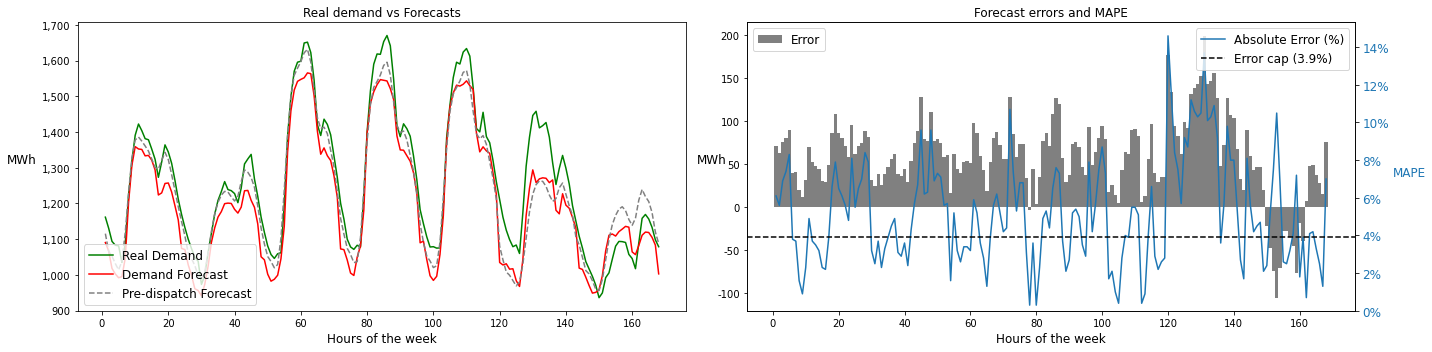

Wall time: 3.29 s


In [17]:
%%time
# ------- Forecast with generic model ---------
y_pred_train = generic_model.predict(X_train)
y_pred_test = generic_model.predict(X_test)

# Calculate weekly MAPE and RMSE to improve
MAPE2improve = mean_absolute_percentage_error(y_test, y_pre_disp)
RMSE2improve = round(np.sqrt(mean_squared_error(y_test, y_pre_disp)),2)

# Compare average training score with average test score
RMSE_train_score = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),2)
RMSE_test_score  = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),2)
MAPE_train_score = round(mean_absolute_percentage_error(y_train, y_pred_train),2)
MAPE_test_score  = round(mean_absolute_percentage_error(y_test, y_pred_test),2)

print('Train RMSE:', RMSE_train_score, 'MWh')
print('Test  RMSE:', RMSE_test_score, 'MWh')
print('Train MAPE:', MAPE_train_score, '%')
print('Test  MAPE:', MAPE_test_score, '%')
print('')
print('RMSE to improve:', RMSE2improve, 'MWh')
print('MAPE to improve:', MAPE2improve, '%')

# Show hourly forecast and errors
plot_test_forecast(y_test, y_pred_test, y_pre_disp)

Lastly, take a look at the imported Optuna study to see the optimization progress and the hyperparameters impact. <br>
Notice that the objective value is **-RMSE**, and the optimization is trying to maximize this value, as defined in *model_hyperparameter_search* function.

In [18]:
# Visualize the optimization progress along the trials
optuna.visualization.plot_optimization_history(generic_model_study)

In [19]:
# Visualize the optimization progress by parameter
optuna.visualization.plot_slice(generic_model_study)